In [1]:
#import necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

# supress error
pd.options.mode.chained_assignment = None

# load data

In [2]:
# importing data and reading data from csv file
# entries do have whitespace at before chars --> remove them with skipinitialspace
data = pd.read_csv('data/adult.csv', header = None, skipinitialspace=True)
# name columns
data.columns = ['age', 'workclass', "fnlwgt", "education", "education_num", "marital_status", "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss", "hours_per_week", "native_country", "income" ]
# show dataset
data.head(2)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K


# describe dataset

In [3]:
pd.set_option("max_colwidth", None)
desc = ['Describes the age of individuals.','Different types of employment (e.g. State-gov, Never-worked).','If two samples have the same(or similar) fnlwgt they have similar characteristics, demographically speaking. They are not standardized across different states.',
       'Different types of academic degrees (e.g. Bachelor).','Number of years spent in education.','The distinct options that describe a person´s relationship with a significant other (e.g. Married).',
        'A job or profession (e.g. Sales, Tech-support).','The way in which two or more people or groups regard and behave towards each other (e.g. Wife, Husband).','Race of the person (e.g. White, Black).','Gender of the person (Male or Female).','Is the profit one earns on the sale of an asset like stocks.',
        'Loss incurred when a capital asset (e.g. a stock) decreases in value.','The time a person works per week.','Country of origin.','Annual salary.']
data_details = pd.DataFrame(list(zip(data.columns, desc)), columns =['Column', 'Description'])
data_details

,Column,Description
0,age,Describes the age of individuals.
1,workclass,"Different types of employment (e.g. State-gov, Never-worked)."
2,fnlwgt,"The idea is that if two samples have the same(or similar) fnlwgt they have similar characteristics, demographically speaking. They are not standardized across different states."
3,education,Different types of academic degrees (e.g. Bachelor).
4,education_num,Number of years spent in education.
5,marital_status,The distinct options that describe a person´s relationship with a significant other (e.g. Married).
6,occupation,"A job or profession (e.g. Sales, Tech-support)."
7,relationship,"The way in which two or more people or groups regard and behave towards each other (e.g. Wife, Husband)."
8,race,"Race of the person (e.g. White, Black)."
9,sex,Gender of the person (Male or Female).


In [4]:
# 32561 rows, 15 columns
data.shape

(32561, 15)

In [5]:
# Check for Null Data
data.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
dtype: int64

In [6]:
# dataset has no NaNs but a lot of ?
data.select_dtypes(object).apply(lambda x: x.str.contains('?', regex=False)).sum()

workclass         1836
education            0
marital_status       0
occupation        1843
relationship         0
race                 0
sex                  0
native_country     583
income               0
dtype: int64

In [7]:
# Get data types
data.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
income            object
dtype: object

In [8]:
# show all duplicated entries of the dataset
print('Duplicated entries:',data.duplicated().sum())

Duplicated entries: 24


## visualization

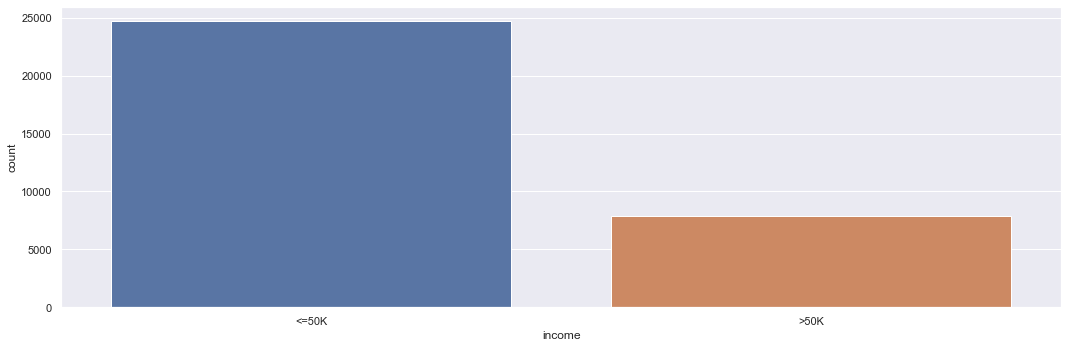

In [9]:
# Count of >50K & <=50K
sns.set_theme(style="darkgrid")
plt.figure(figsize=(15,5))
sns.countplot(x="income", data=data)
plt.tight_layout()
plt.show()

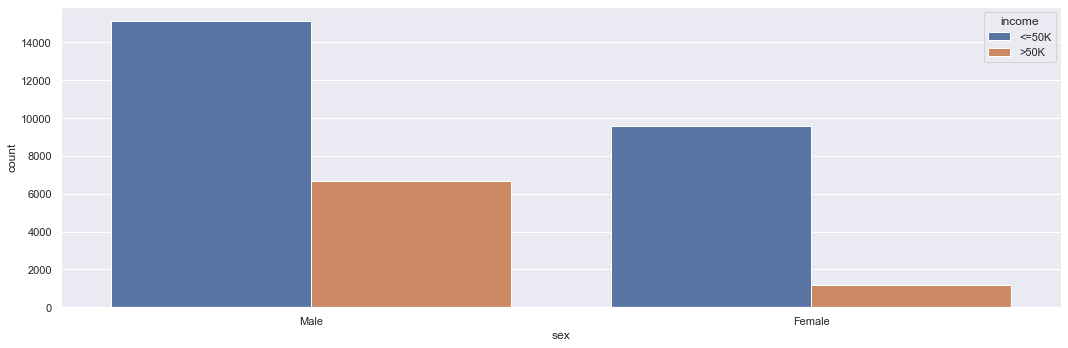

In [10]:
#difference male and female
plt.figure(figsize=(15,5))
sns.countplot(x="sex", hue='income', data=data)
plt.tight_layout()
plt.show()

In [11]:
#split age in different groups for visualization
data_age = []
def age_group(x):
    x = int(x)
    x = abs(x)
    if( 18 < x < 31 ):
        return "19-30"
    if( 30 < x < 41 ):
        return "31-40"
    if( 40 < x < 51 ):
        return "41-50"
    if( 50 < x < 61 ):
        return "51-60"
    if( 60 < x < 71 ):
        return "61-70"
    else:
        return "Greater than 70"

data_age = data['age'].apply(age_group)

Text(0.5, 1.0, 'Income of Individuals of Different Age Groups')

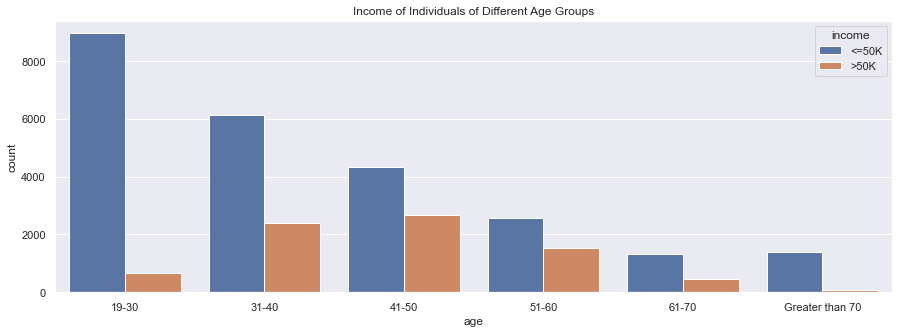

In [12]:
#visualization of age groups
plt.figure(figsize=(15,5))
order_list = ['19-30', '31-40', '41-50', '51-60', '61-70', 'Greater than 70']
sns.countplot(x = data_age, hue = data['income'], order = order_list, data=data)
plt.title('Income of Individuals of Different Age Groups')

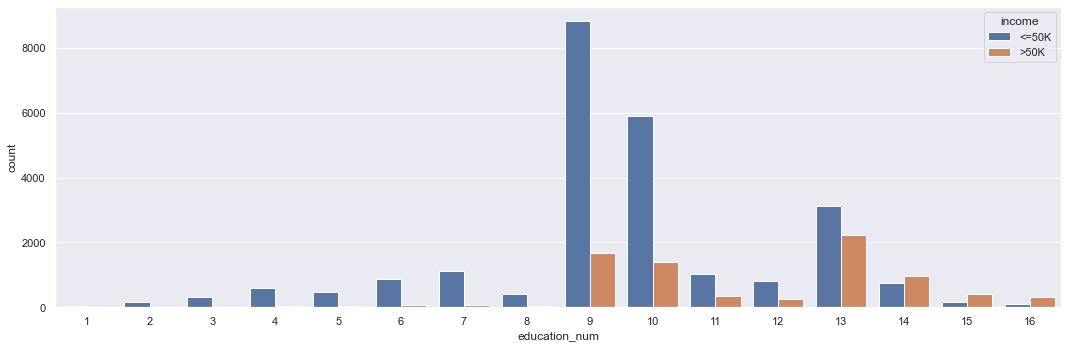

In [13]:
# income in correlation with education years
plt.figure(figsize=(15,5))
sns.countplot(x = 'education_num', hue = 'income', data = data)
plt.tight_layout()
plt.show()

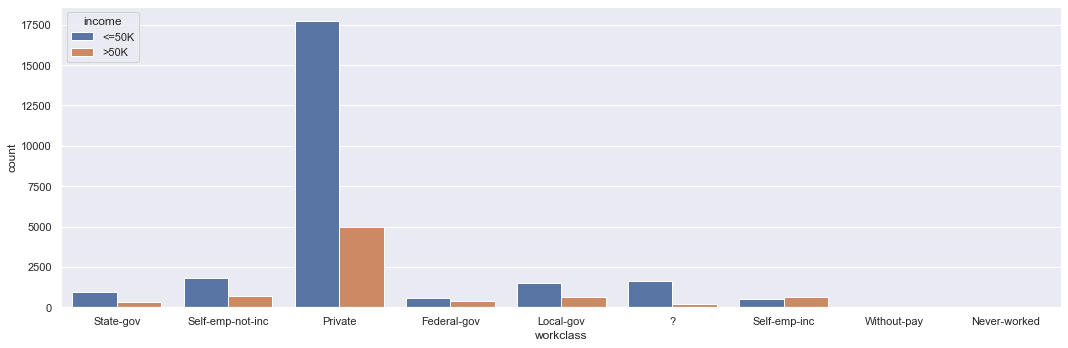

In [14]:
#Plotting workclass corresponding to the income
plt.figure(figsize=(15,5))
sns.countplot(x = 'workclass', hue = 'income', data = data)
plt.tight_layout()
plt.show()

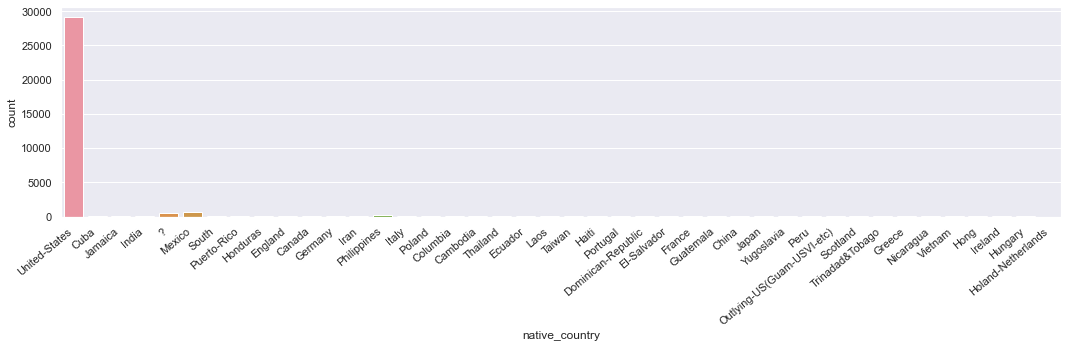

In [15]:
#Plot of Country corresponding to income
# plt.bar(count.index, count.values)
# plt.xlabel('Countries')
# plt.ylabel('Count')
# plt.title('Count from each Country')
plt.figure(figsize=(15,5))
ax = sns.countplot(x = 'native_country', data = data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

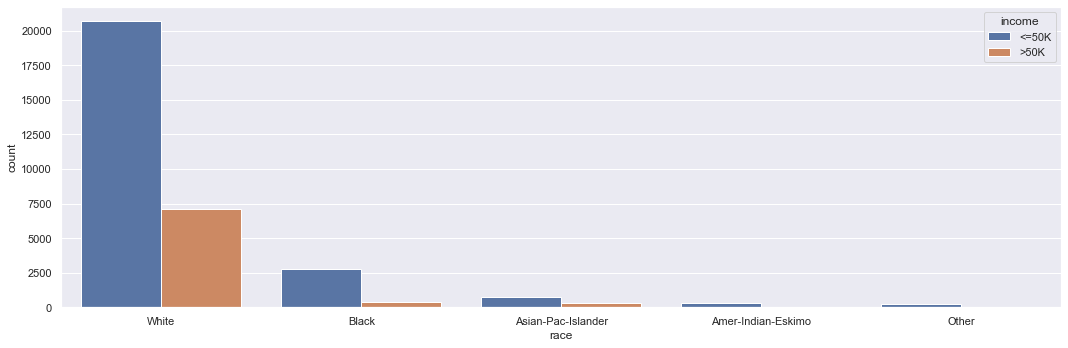

In [16]:
# visualize race
plt.figure(figsize=(15,5))
ax = sns.countplot(x = 'race', hue = 'income', data = data)
plt.tight_layout()
plt.show()

# preprocess data

In [17]:
# replace ? with Nans
data = data.replace('?', np.NaN )

In [18]:
# Check again for null data
data.isna().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education_num        0
marital_status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     583
income               0
dtype: int64

In [19]:
# remove 24 duplicates
data = data.drop_duplicates()
print('Duplicated entries: ', data.duplicated().sum())

Duplicated entries:  0


In [20]:
print(data.shape)
print(data.capital_gain.unique().shape)
data.capital_loss.unique().shape

(32537, 15)
(119,)


(92,)

In [21]:
data.eq(0).sum()

age                   0
workclass             0
fnlwgt                0
education             0
education_num         0
marital_status        0
occupation            0
relationship          0
race                  0
sex                   0
capital_gain      29825
capital_loss      31018
hours_per_week        0
native_country        0
income                0
dtype: int64

In [22]:
# dropping unimportant columns
# The ‘fnlwgt’ variable (stands for final weight) is removed as it has no predictive power since it is a feature aimed to allocate similar weights to people with similar demographic characteristics. 
# capital gain and capital loss are mostly 0
# education can be described by education-num 
data.drop(['fnlwgt', 'capital_gain', 'capital_loss', 'education'], axis=1, inplace=True)

## approach 1 with dropping rows with any na in it

In [23]:
# drop Na 
data_dropped = data.dropna(how='any')
# reset index after dropping rows
data_dropped = data_dropped.reset_index(drop=True)
print(data_dropped.isna().sum())
print(data_dropped.shape)

age               0
workclass         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
hours_per_week    0
native_country    0
income            0
dtype: int64
(30139, 11)


## approach 2 with replacing na values with mode

In [24]:
data.isnull().sum(axis = 0)

age                  0
workclass         1836
education_num        0
marital_status       0
occupation        1843
relationship         0
race                 0
sex                  0
hours_per_week       0
native_country     582
income               0
dtype: int64

In [25]:
print(data['occupation'].describe())
data['occupation'] = data['occupation'].fillna('Prof-specialty')

count              30694
unique                14
top       Prof-specialty
freq                4136
Name: occupation, dtype: object


In [26]:
print(data['workclass'].describe())
data['workclass'] = data['workclass'].fillna('Private')

count       30701
unique          8
top       Private
freq        22673
Name: workclass, dtype: object


In [27]:
print(data['native_country'].describe())
data['native_country'] = data['native_country'].fillna('United-States')

count             31955
unique               41
top       United-States
freq              29153
Name: native_country, dtype: object


In [28]:
data.isna().sum()
print(data.shape)

(32537, 11)


## encoding approach 1

In [29]:
# encoding
# 1 = >50K; 0 = <=50K 
encoder_income = LabelEncoder()
data_dropped['income'] = encoder_income.fit_transform(data_dropped['income'])
encoder_worklass = LabelEncoder()
data_dropped['workclass'] = encoder_worklass.fit_transform(data_dropped['workclass'])
encoder_occupation = LabelEncoder()
data_dropped['occupation'] = encoder_occupation.fit_transform(data_dropped['occupation'])
encoder_relationship = LabelEncoder()
data_dropped['relationship'] = encoder_relationship.fit_transform(data_dropped['relationship'])
encoder_race = LabelEncoder()
data_dropped['race'] = encoder_race.fit_transform(data_dropped['race'])
encoder_sex = LabelEncoder()
data_dropped['sex'] = encoder_sex.fit_transform(data_dropped['sex'])
encoder_nativecountry  = LabelEncoder()
data_dropped['native_country'] = encoder_nativecountry.fit_transform(data_dropped['native_country'])
encoder_maritalstatus  = LabelEncoder()
data_dropped['marital_status'] = encoder_maritalstatus.fit_transform(data_dropped['marital_status'])
data_dropped.head()

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,hours_per_week,native_country,income
0,39,5,13,4,0,1,4,1,40,38,0
1,50,4,13,2,3,0,4,1,13,38,0
2,38,2,9,0,5,1,4,1,40,38,0
3,53,2,7,2,5,0,2,1,40,38,0
4,28,2,13,2,9,5,2,0,40,4,0


In [30]:
#Splitting the data set into features and outcome
X_dropped = data_dropped.drop(['income'], axis=1)
Y_dropped = data_dropped['income']
print(Y_dropped)
X_dropped.head()

0        0
1        0
2        0
3        0
4        0
        ..
30134    0
30135    1
30136    0
30137    0
30138    1
Name: income, Length: 30139, dtype: int32


,age,workclass,education_num,marital_status,occupation,relationship,race,sex,hours_per_week,native_country
0,39,5,13,4,0,1,4,1,40,38
1,50,4,13,2,3,0,4,1,13,38
2,38,2,9,0,5,1,4,1,40,38
3,53,2,7,2,5,0,2,1,40,38
4,28,2,13,2,9,5,2,0,40,4


## encoding approach 2

In [31]:
# encoding
# 1 = >50K; 0 = <=50K 
encoder_income = LabelEncoder()
data['income'] = encoder_income.fit_transform(data['income'])
encoder_worklass = LabelEncoder()
data['workclass'] = encoder_worklass.fit_transform(data['workclass'])
encoder_occupation = LabelEncoder()
data['occupation'] = encoder_occupation.fit_transform(data['occupation'])
encoder_relationship = LabelEncoder()
data['relationship'] = encoder_relationship.fit_transform(data['relationship'])
encoder_race = LabelEncoder()
data['race'] = encoder_race.fit_transform(data['race'])
encoder_sex = LabelEncoder()
data['sex'] = encoder_sex.fit_transform(data['sex'])
encoder_nativecountry  = LabelEncoder()
data['native_country'] = encoder_nativecountry.fit_transform(data['native_country'])
encoder_maritalstatus  = LabelEncoder()
data['marital_status'] = encoder_maritalstatus.fit_transform(data['marital_status'])
data.head()

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,hours_per_week,native_country,income
0,39,6,13,4,0,1,4,1,40,38,0
1,50,5,13,2,3,0,4,1,13,38,0
2,38,3,9,0,5,1,4,1,40,38,0
3,53,3,7,2,5,0,2,1,40,38,0
4,28,3,13,2,9,5,2,0,40,4,0


In [32]:
#Splitting the data set into features and outcome
X = data.drop(['income'], axis=1)
Y = data['income']
print(Y)
X.head()

0        0
1        0
2        0
3        0
4        0
        ..
32556    0
32557    1
32558    0
32559    0
32560    1
Name: income, Length: 32537, dtype: int32


,age,workclass,education_num,marital_status,occupation,relationship,race,sex,hours_per_week,native_country
0,39,6,13,4,0,1,4,1,40,38
1,50,5,13,2,3,0,4,1,13,38
2,38,3,9,0,5,1,4,1,40,38
3,53,3,7,2,5,0,2,1,40,38
4,28,3,13,2,9,5,2,0,40,4


# train data 

In [33]:
# define k-fold properties
# @Tim welches n_splits ist sinnvoll?
kf = KFold(n_splits=10, shuffle=True)

## approach 1

In [34]:
# define arrays to save the accuracy of every step of k-fold cross validation
accuracy_kNeighbor_1 = []
accuracy_decisionTree_1 = []
accuracy_randomForest_1 = []
accuracy_logisticRegression_1 = []
accuracy_neuronalNet_1 = []

In [35]:
X_dropped = X_dropped.to_numpy()
Y_dropped = Y_dropped.to_numpy()

In [36]:
for train_index, test_index in kf.split(X_dropped):
    
        X_train, X_test = X_dropped[train_index], X_dropped[test_index]
        Y_train, Y_test = Y_dropped[train_index], Y_dropped[test_index]
        
    #K nearest neighbor
        kNeighbor = KNeighborsClassifier(n_neighbors=5)
        #train random forest only on training data
        kNeighbor = kNeighbor.fit(X_train, Y_train)
        #test random forest with test data
        kNeighbor_pred = kNeighbor.predict(X_test)
        kNeighbor_accuracy = accuracy_score(Y_test, kNeighbor_pred)
        print(f'K Nearest Neighbor: {kNeighbor_accuracy}')
        accuracy_kNeighbor_1.append(kNeighbor_accuracy)
        #cm_KNN_1.append(confusion_matrix(Y_test, kNeighbor_pred))
        
    #Decision Tree
        decisionTree = DecisionTreeClassifier(random_state=0, criterion = 'entropy')
        #train decision tree only on training data
        decisionTree = decisionTree.fit(X_train, Y_train)
        #test decision tree with test data
        decisionTree_pred = decisionTree.predict(X_test)
        decisionTree_accuracy = accuracy_score(Y_test, decisionTree_pred)
        print(f'Decision Tree: {decisionTree_accuracy}')
        accuracy_decisionTree_1.append(decisionTree_accuracy)
        
    #Random Forest
        randomForest = RandomForestClassifier(max_depth=2, random_state=0)
        #train random forest only on training data
        randomForest = randomForest.fit(X_train, Y_train)
        #test random forest with test data
        randomForest_pred = randomForest.predict(X_test)
        randomForest_accuracy = accuracy_score(Y_test, randomForest_pred)
        print(f'Random Forest: {randomForest_accuracy}')
        accuracy_randomForest_1.append(randomForest_accuracy)
        
    #Logistic Regression
        logisticRegression = LogisticRegression(random_state=0, max_iter=500)
        #train logistic regression only on training data
        logisticRegression = logisticRegression.fit(X_train, Y_train)
        #test random forest with test data
        logisticRegression_pred = logisticRegression.predict(X_test)
        logisticRegression_accuracy = accuracy_score(Y_test, logisticRegression_pred)
        print(f'Logistic Regression: {logisticRegression_accuracy}')
        accuracy_logisticRegression_1.append(logisticRegression_accuracy)
        
    #Neuronal Net
        neuronalNet = MLPClassifier(random_state=1, max_iter=500).fit(X_train, Y_train)
        neuronalNet_pred = neuronalNet.predict(X_test)
        neuronalNet_accuracy = accuracy_score(Y_test, neuronalNet_pred)
        print(f'Neuronales Net: {neuronalNet_accuracy}')
        accuracy_neuronalNet_1.append(neuronalNet_accuracy)
        print('\n')

K Nearest Neighbor: 0.7992700729927007
Decision Tree: 0.7760451227604512
Random Forest: 0.805242203052422
Logistic Regression: 0.7979429329794293
Neuronales Net: 0.8175182481751825


K Nearest Neighbor: 0.809555408095554
Decision Tree: 0.7816854678168547
Random Forest: 0.8115461181154612
Logistic Regression: 0.8002654280026543
Neuronales Net: 0.8307896483078965


K Nearest Neighbor: 0.8085600530856005
Decision Tree: 0.7932979429329794
Random Forest: 0.8191771731917717
Logistic Regression: 0.8092236230922363
Neuronales Net: 0.8327803583278036


K Nearest Neighbor: 0.8039150630391506
Decision Tree: 0.7826808228268082
Random Forest: 0.8078964830789648
Logistic Regression: 0.8088918380889184
Neuronales Net: 0.8324485733244857


K Nearest Neighbor: 0.7989382879893829
Decision Tree: 0.7690776376907764
Random Forest: 0.8085600530856005
Logistic Regression: 0.7986065029860651
Neuronales Net: 0.818513603185136


K Nearest Neighbor: 0.7986065029860651
Decision Tree: 0.7856668878566688
Random For

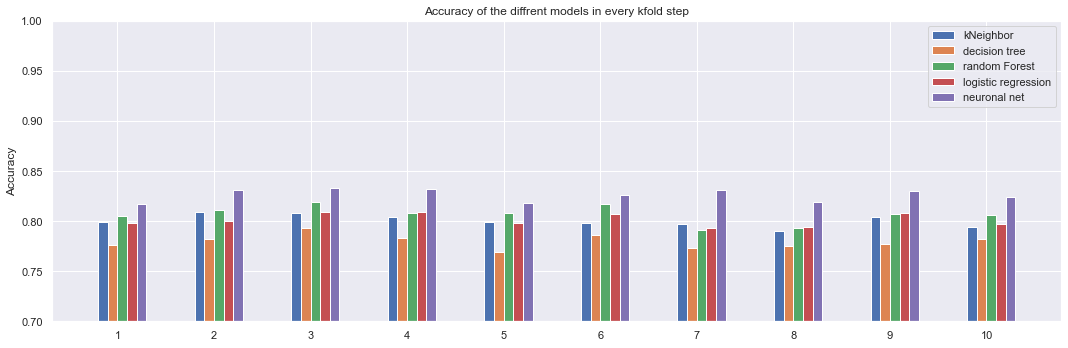

In [37]:
# print accuracy of each kfold step
plt.figure(figsize=(15,5))
ax = plt.subplot()
width = 0.1

X_label = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
_X = np.arange(len(X_label))

ax.bar(_X, accuracy_kNeighbor_1, width, label='kNeighbor')
ax.bar(_X + width, accuracy_decisionTree_1, width, label='decision tree')
ax.bar(_X + (2*width), accuracy_randomForest_1, width, label='random Forest')
ax.bar(_X + (3*width), accuracy_logisticRegression_1, width, label='logistic regression')
ax.bar(_X + (4*width), accuracy_neuronalNet_1, width, label='neuronal net')

ax.set_ylabel('Accuracy')
ax.set_ylim(0.7,1)
ax.set_xticks(_X + width + width/2)
ax.set_xticklabels(X_label)
ax.set_title('Accuracy of the diffrent models in every kfold step')
ax.legend()

plt.tight_layout()

plt.show()

In [38]:
# calculate average accuracy
avg_kNeigbor_1 = sum(accuracy_kNeighbor_1)/len(accuracy_kNeighbor_1)
avg_decisionTree_1 = sum(accuracy_decisionTree_1)/len(accuracy_decisionTree_1)
avg_randomForest_1 = sum(accuracy_randomForest_1)/len(accuracy_randomForest_1)
avg_logisticRegression_1 = sum(accuracy_logisticRegression_1)/len(accuracy_logisticRegression_1)
avg_neuronalNet_1 = sum(accuracy_neuronalNet_1)/len(accuracy_neuronalNet_1)

In [39]:
print(f'KNeighbor: {avg_kNeigbor_1}')
print(f'Decision Tree: {avg_decisionTree_1}')
print(f'Random Forest: {avg_randomForest_1}')
print(f'Logistic Regression: {avg_logisticRegression_1}')
print(f'Neuronal Net: {avg_neuronalNet_1}')

KNeighbor: 0.8003913036871191
Decision Tree: 0.7796211880788205
Random Forest: 0.8068283511992161
Logistic Regression: 0.8014531148037778
Neuronal Net: 0.8262383685295592


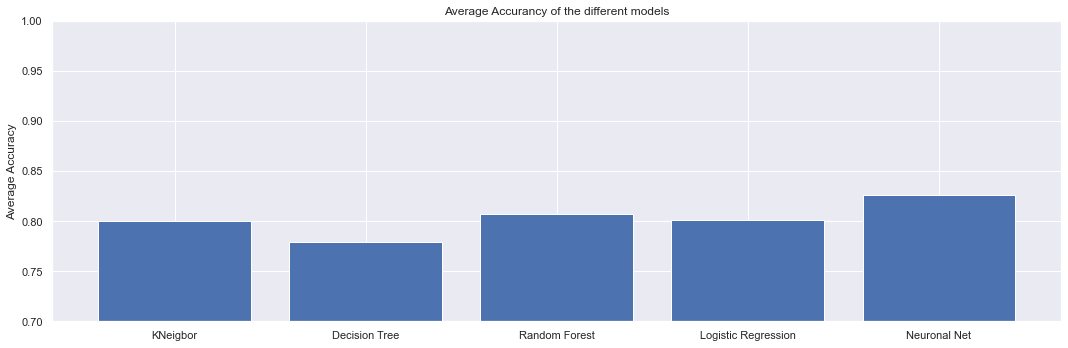

In [40]:
# print average accuracy of each model
plt.figure(figsize=(15,5))
ax = plt.subplot()
models = ['KNeigbor', 'Decision Tree', 'Random Forest', 'Logistic Regression', 'Neuronal Net']
avg_accuracies_1 = [avg_kNeigbor_1, avg_decisionTree_1, avg_randomForest_1, avg_logisticRegression_1, avg_neuronalNet_1] 

ax.bar(models, avg_accuracies_1)

ax.set_ylabel('Average Accuracy')
ax.set_ylim(0.7,1)
ax.set_title('Average Accurancy of the different models')

plt.tight_layout()
plt.show()

## aproach 2

In [41]:
# define arrays to save the accuracy of every step of k-fold cross validation
accuracy_kNeighbor_2 = []
accuracy_decisionTree_2 = []
accuracy_randomForest_2 = []
accuracy_logisticRegression_2 = []
accuracy_neuronalNet_2 = []

In [42]:
X = X.to_numpy()
Y = Y.to_numpy()

In [43]:
for train_index, test_index in kf.split(X):
    
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
    #KNeighbor
        kNeighbor = KNeighborsClassifier(n_neighbors=5)
        #train random forest only on training data
        kNeighbor = kNeighbor.fit(X_train, Y_train)
        #test random forest with test data
        kNeighbor_pred = kNeighbor.predict(X_test)
        kNeighbor_accuracy = accuracy_score(Y_test, kNeighbor_pred)
        print(f'K Nearest Neighbor: {kNeighbor_accuracy}')
        accuracy_kNeighbor_2.append(kNeighbor_accuracy)
        
    #Decision Tree
        decisionTree = DecisionTreeClassifier(random_state=0, criterion = 'entropy')
        #train decision tree only on training data
        decisionTree = decisionTree.fit(X_train, Y_train)
        #test decision tree with test data
        decisionTree_pred = decisionTree.predict(X_test)
        decisionTree_accuracy = accuracy_score(Y_test, decisionTree_pred)
        print(f'Decision Tree: {decisionTree_accuracy}')
        accuracy_decisionTree_2.append(decisionTree_accuracy)
        
    #Random Forest
        randomForest = RandomForestClassifier(max_depth=2, random_state=0)
        #train random forest only on training data
        randomForest = randomForest.fit(X_train, Y_train)
        #test random forest with test data
        randomForest_pred = randomForest.predict(X_test)
        randomForest_accuracy = accuracy_score(Y_test, randomForest_pred)
        print(f'Random Forest: {randomForest_accuracy}')
        accuracy_randomForest_2.append(randomForest_accuracy)
        
    #Logistic Regression
        logisticRegression = LogisticRegression(random_state=0, max_iter=500)
        #train logistic regression only on training data
        logisticRegression = logisticRegression.fit(X_train, Y_train)
        #test random forest with test data
        logisticRegression_pred = logisticRegression.predict(X_test)
        logisticRegression_accuracy = accuracy_score(Y_test, logisticRegression_pred)
        print(f'Logistic Regression: {logisticRegression_accuracy}')
        accuracy_logisticRegression_2.append(logisticRegression_accuracy)
        
    #Neuronal Net
        neuronalNet = MLPClassifier(random_state=1, max_iter=500).fit(X_train, Y_train)
        neuronalNet_pred = neuronalNet.predict(X_test)
        neuronalNet_accuracy = accuracy_score(Y_test, neuronalNet_pred)
        print(f'Neuronales Net: {neuronalNet_accuracy}')
        accuracy_neuronalNet_2.append(neuronalNet_accuracy)
        print('\n')

K Nearest Neighbor: 0.7947141979102643
Decision Tree: 0.7698217578365089
Random Forest: 0.7821143208358943
Logistic Regression: 0.7919483712354026
Neuronales Net: 0.8113091579594346


K Nearest Neighbor: 0.8063921327596804
Decision Tree: 0.7907191149354641
Random Forest: 0.806699446834665
Logistic Regression: 0.8100799016594961
Neuronales Net: 0.8211432083589428


K Nearest Neighbor: 0.8060848186846957
Decision Tree: 0.7885679164105716
Random Forest: 0.809157959434542
Logistic Regression: 0.803318992009834
Neuronales Net: 0.826060233558697


K Nearest Neighbor: 0.8017824216349109
Decision Tree: 0.7851874615857406
Random Forest: 0.8005531653349723
Logistic Regression: 0.8073140749846343
Neuronales Net: 0.8248309772587584


K Nearest Neighbor: 0.8020897357098955
Decision Tree: 0.7796558082360172
Random Forest: 0.8039336201598033
Logistic Regression: 0.8042409342347879
Neuronales Net: 0.8229870928088506


K Nearest Neighbor: 0.8011677934849416
Decision Tree: 0.7842655193607867
Random Fore

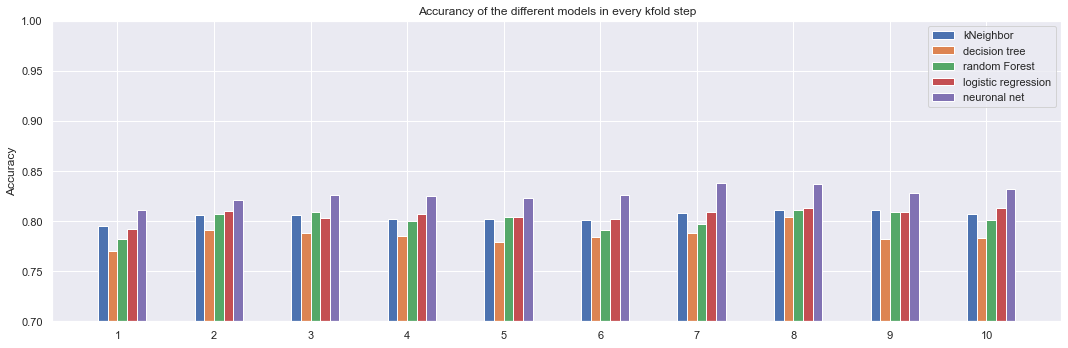

In [44]:
# print accuracy of each kfold step
plt.figure(figsize=(15,5))
ax = plt.subplot()
width = 0.1

X_label = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
_X = np.arange(len(X_label))

ax.bar(_X, accuracy_kNeighbor_2, width, label='kNeighbor')
ax.bar(_X + width, accuracy_decisionTree_2, width, label='decision tree')
ax.bar(_X + (2*width), accuracy_randomForest_2, width, label='random Forest')
ax.bar(_X + (3*width), accuracy_logisticRegression_2, width, label='logistic regression')
ax.bar(_X + (4*width), accuracy_neuronalNet_2, width, label='neuronal net')

ax.set_ylabel('Accuracy')
ax.set_ylim(0.7,1)
ax.set_xticks(_X + width + width/2)
ax.set_xticklabels(X_label)
ax.set_title('Accurancy of the different models in every kfold step')
ax.legend()

plt.tight_layout()

plt.show()

In [45]:
# calculate average accuracy
avg_kNeigbor_2 = sum(accuracy_kNeighbor_2)/len(accuracy_kNeighbor_2)
avg_decisionTree_2 = sum(accuracy_decisionTree_2)/len(accuracy_decisionTree_2)
avg_randomForest_2 = sum(accuracy_randomForest_2)/len(accuracy_randomForest_2)
avg_logisticRegression_2 = sum(accuracy_logisticRegression_2)/len(accuracy_logisticRegression_2)
avg_neuronalNet_2 = sum(accuracy_neuronalNet_2)/len(accuracy_neuronalNet_2)

In [46]:
print(f'KNeighbor: {avg_kNeigbor_2}')
print(f'Decision Tree: {avg_decisionTree_2}')
print(f'Random Forest: {avg_randomForest_2}')
print(f'Logistic Regression: {avg_logisticRegression_2}')
print(f'Neuronal Net: {avg_neuronalNet_2}')

KNeighbor: 0.8050224453584616
Decision Tree: 0.7855061216245757
Random Forest: 0.8013651622416148
Logistic Regression: 0.8064055192965464
Neuronal Net: 0.8268438230437754


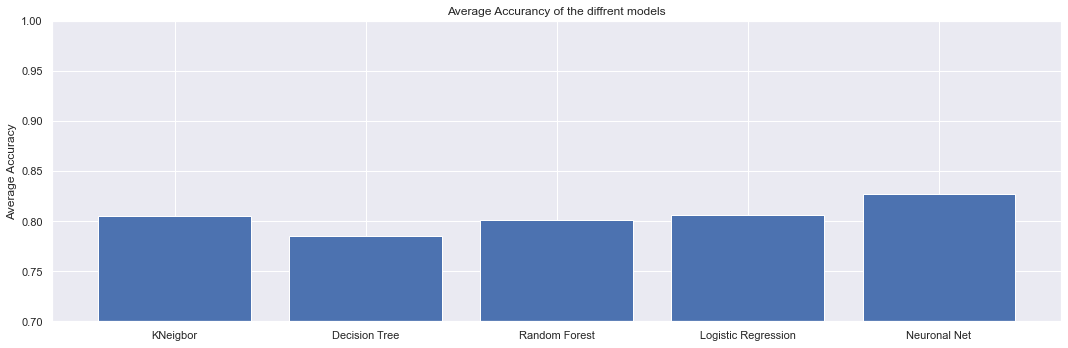

In [47]:
# print average accuracy of each model
plt.figure(figsize=(15,5))
ax = plt.subplot()
models = ['KNeigbor', 'Decision Tree', 'Random Forest', 'Logistic Regression', 'Neuronal Net']
avg_accuracies_2 = [avg_kNeigbor_2, avg_decisionTree_2, avg_randomForest_2, avg_logisticRegression_2, avg_neuronalNet_2] 

ax.bar(models, avg_accuracies_2)

ax.set_ylabel('Average Accuracy')
ax.set_ylim(0.7,1)
ax.set_title('Average Accurancy of the diffrent models')

plt.tight_layout()
plt.show()

# evaluation

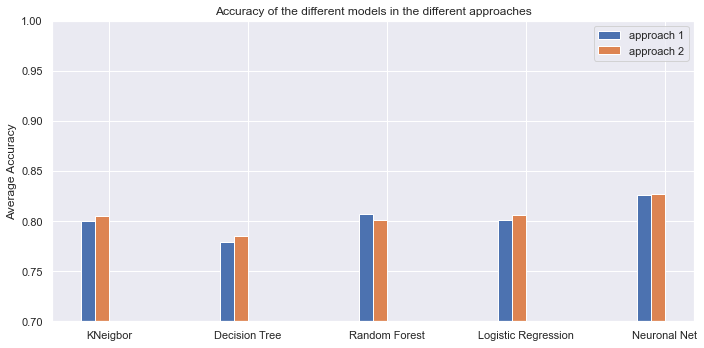

In [48]:
# print average accuracy of each approach
plt.figure(figsize=(10,5))
ax = plt.subplot()
width = 0.1

X_label = ['KNeigbor', 'Decision Tree', 'Random Forest', 'Logistic Regression', 'Neuronal Net']
_X = np.arange(len(X_label))

ax.bar(_X, avg_accuracies_1, width, label='approach 1')
ax.bar(_X + width, avg_accuracies_2, width, label='approach 2')

ax.set_ylabel('Average Accuracy')
ax.set_ylim(0.7,1)
ax.set_xticks(_X + width + width/2)
ax.set_xticklabels(X_label)
ax.set_title('Accuracy of the different models in the different approaches')
ax.legend()

plt.tight_layout()

plt.show()